# Twitter Sentiment Analysis for ChatGPT

## 0. Notes
* This project is based on the tweets about ChatGPT after the announcement about release of GPT-4. 
* The aim of the project is to determine the thoughts and tendencies of twitter users about ChatGPT, one of today's popular applications.
* Various sources and Github repos were used in the project. Notes and references are given where relevant.
* Since it takes a long time to extract the data, determine sentiment scores, etc., the processed version of the data was used. Notes and explanations have been made where relevant.

## 1. Scraping Tweets Data

* The "snscrape" library was used for tweet scraping.
* You can review the notebook with detailed explanations from the link. 
* I would like to thank Yavuz Kömeçoğlu and MoreThan101 for this scrapping work.
* https://github.com/yavuzKomecoglu/twitter-sentiment-analysis-morethan101

## 2. Readind Data and Exploratory Data Analysis

* The data consists of 100,000 tweets (include duplicates) in English containing the word "chatgpt" between 2023-03-18 and 2023-03-21.
* In the shared data,  usernames are masked, tags (@username) and links in the tweet are deleted.
* Variables;
    * ID: unique tweet id
    * Date: date the tweet was sent
    * Username: username of the person who tweeted (masked for this data and non-real ids are generated)
    * Tweet: content of the tweet (tags and links deleted)
    * ReplyCount: number of replies to tweets
    * RetweetCount: number of retweets to tweets
    * LikeCount: number of likes to tweets
    * QuotesCount: number of quotes to tweets

### 2.1 Importing Libraries

!pip install emoji

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import re
import emoji
from tqdm.notebook import tqdm
import warnings

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Set display options
pd.set_option('display.float_format', '{:.4f}'.format)

# Ignore warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.2 Importing Data and First Impressions

In [2]:
# Reading dataset
df = pd.read_csv("chatgpt-tweets-data-20230310-20230322.csv")
# Number of tweets
print("The number of unique tweets:", df.shape[0])

The number of unique tweets: 98759


In [3]:
df.head()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #推特账号 m...",0,0,0,0
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI – ChatGPT #0018,1,0,0,0
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98759 entries, 0 to 98758
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            98759 non-null  int64 
 1   Date          98759 non-null  object
 2   Username      98759 non-null  object
 3   Tweet         98759 non-null  object
 4   ReplyCount    98759 non-null  int64 
 5   RetweetCount  98759 non-null  int64 
 6   LikeCount     98759 non-null  int64 
 7   QuoteCount    98759 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 6.0+ MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,98759.0000,1637481406058671104.0000,563281176533015.5000,1636521747540242432.0000,1636926715759888384.0000,1637527761219645440.0000,1637975215293546496.0000,1638329623946878976.0000
ReplyCount,98759.0000,1.3467,32.8560,0.0000,0.0000,0.0000,1.0000,4984.0000
RetweetCount,98759.0000,1.3948,35.9637,0.0000,0.0000,0.0000,0.0000,4076.0000
LikeCount,98759.0000,9.7873,245.5766,0.0000,0.0000,0.0000,2.0000,36112.0000
QuoteCount,98759.0000,0.2590,19.7567,0.0000,0.0000,0.0000,0.0000,5415.0000


### 2.3 Generating New Time Variables

In [6]:
# Generating new time variables
df['Date'] = pd.to_datetime(df['Date'])
df['OnlyDate'] = df['Date'].dt.date
df['OnlyDate'] = pd.to_datetime(df['OnlyDate'])
df['OnlyHour'] = df['Date'].dt.hour
df['OnlyMin'] = df['Date'].dt.minute

In [7]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98759 entries, 0 to 98758
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   ID            98759 non-null  int64              
 1   Date          98759 non-null  datetime64[ns, UTC]
 2   Username      98759 non-null  object             
 3   Tweet         98759 non-null  object             
 4   ReplyCount    98759 non-null  int64              
 5   RetweetCount  98759 non-null  int64              
 6   LikeCount     98759 non-null  int64              
 7   QuoteCount    98759 non-null  int64              
 8   OnlyDate      98759 non-null  datetime64[ns]     
 9   OnlyHour      98759 non-null  int64              
 10  OnlyMin       98759 non-null  int64              
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), int64(7), object(2)
memory usage: 8.3+ MB


,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount,OnlyDate,OnlyHour,OnlyMin
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0,2023-03-21,23,59
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #推特账号 m...",0,0,0,0,2023-03-21,23,59
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0,2023-03-21,23,59
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI – ChatGPT #0018,1,0,0,0,2023-03-21,23,59
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0,2023-03-21,23,59


In [8]:
df['OnlyDate'].value_counts()

2023-03-21    25074
2023-03-17    22923
2023-03-20    20790
2023-03-19    15187
2023-03-18    14785
Name: OnlyDate, dtype: int64

### 2.4 First Exploratory Data Analysis Works

df['Date'].value_counts().resample('d').sum()

df['OnlyHour'].value_counts().sort_index

In [9]:
def plot_time_variable(col, ylim_lower = 10000, ylim_upper = 30000):
    """
    Given a pandas dataframe and the name of a time column, this function will plot a line graph of time counts
    using the specified column.
    
    Parameters:
    -----------
    col : str
        The name of a column in the pandas dataframe.
    """
    
    if df[col].dtype == "int64":
        time_variable_counts = df[col].value_counts().sort_index()
        
    else:
        # calculate the count of dates using resample
        time_variable_counts = df[col].value_counts().resample('D').sum()

    # set the size of the figure
    plt.figure(figsize=(12, 8))

    # plot the counts using a line graph
    time_variable_counts.plot(kind='line', marker='o', markersize=8)

    # set the y-axis limits to a specific range
    plt.ylim(ylim_lower, ylim_upper)

    # add graph labels and titles
    plt.title(f"{col} Counts", fontsize=16)
    plt.xlabel(f"{col}", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(rotation=45, ha='right') # rotate x-axis labels for readability
    plt.grid(axis='y', linestyle='--')

    # display the graph
    plt.show()

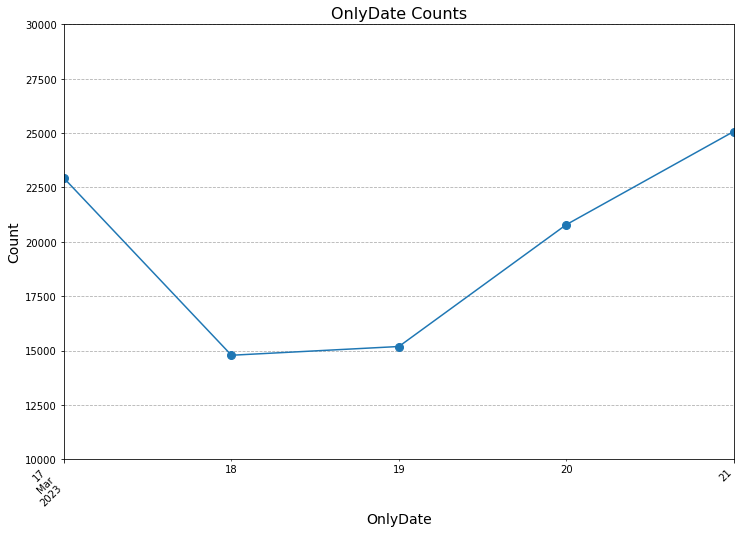

In [10]:
plot_time_variable('OnlyDate')

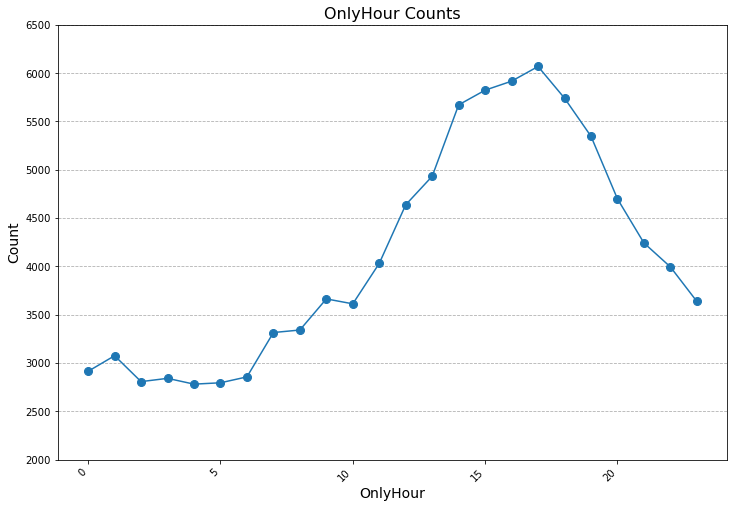

In [11]:
plot_time_variable('OnlyHour', 2000,6500)

In [95]:
def get_top_words(df, column_name, top_n=20):
    # get the list of tweets from the specified column
    tweets = df[column_name].astype(str).tolist()
    
    # tokenize all the words from the tweets
    words = []
    for tweet in tweets:
        words += word_tokenize(tweet.lower())  # convert to lowercase and tokenize the tweet

    # calculate the frequency distribution of words
    freq_dist = FreqDist(words)

    # return the top n most common words
    return freq_dist.most_common(top_n)

In [13]:
get_top_words(df, "Tweet", 20)

[('#', 105632),
 ('chatgpt', 87176),
 ('.', 80118),
 (',', 64766),
 ('the', 64059),
 ('to', 61979),
 ('a', 42551),
 ('and', 42077),
 ('it', 36961),
 ('i', 36778),
 ('is', 34170),
 ('of', 32172),
 ('for', 24737),
 ('in', 22758),
 ('you', 22560),
 ('ai', 21761),
 (':', 19586),
 ('?', 19311),
 ('that', 18500),
 ('with', 17939)]

## 3. Data Preprocessing for Sentiment Analysis and Model

* Trained model from huggingface
* https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest

### 3.1 Loading Model from HuggingFace and Creating Pipeline

In [2]:
# load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

# create pipeline
sa = pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 3.2 Preprocessing for Sentiment Labeling and Scoring

In [3]:
def preprocess_word(word):
    # Remove punctuation
    #word = word.strip('\'"?!,.():;')
    
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word


def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)


def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)|😉', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet


def remove_emoji(tweet):
    return emoji.replace_emoji(tweet, replace=" ")


def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    
    #Clean only digits
    tweet = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", tweet)
    
    # Replaces URLs with the word URL
    #tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', tweet)
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', tweet)
    
    # Replace @handle with the word USER_MENTION
    #tweet = re.sub(r'@[\S]+', 'USER_MENTION', tweet)
    tweet = re.sub(r'@[\S]+', '', tweet)
    
    # Replaces #hashtag with hashtag
    #tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    tweet = re.sub(r'#(\S+)', '', tweet)
    
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')

    # Replace emojis with either EMO_POS or EMO_NEG
    #tweet = handle_emojis(tweet)

    #remove emojis
    tweet = remove_emoji(tweet)
    
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    words = tweet.split()

    for word in words:
        word = preprocess_word(word)
        processed_tweet.append(word)

    return ' '.join(processed_tweet)

In [16]:
index = 2019
print(df.loc[index].Tweet)
p = sa(df.loc[index].Tweet)
print(p)

Kind of wild that Google just admits their training dataset is your gmail &amp; you’re not getting compensated for any of it.
Considering the amount of data that includes it  guarantees that  if Bard can give ChatGPT a fight, we just entrenched 2 old monopolies &amp; have a legal case
[{'label': 'negative', 'score': 0.6108611226081848}]


In [17]:
pre_twit = preprocess_tweet(df.loc[index].Tweet)
print(pre_twit)
p = sa(pre_twit)
print(p)

kind of wild that google just admits their training dataset is your gmail &amp; you’re not getting compensated for any of it. considering the amount of data that includes it guarantees that if bard can give chatgpt a fight, we just entrenched old monopolies &amp; have a legal case
[{'label': 'negative', 'score': 0.6796212196350098}]


In [18]:
df["processed_tweet"] = df["Tweet"].apply(preprocess_tweet)

In [19]:
pd.set_option('display.max_colwidth', None)

In [20]:
df.iloc[:,[3,-1]].head(20)

,Tweet,processed_tweet
0,ChatGPT is another woke machine.,chatgpt is another woke machine.
1,"of the Atlantic, or only near the Atla #推特账号 more to me than the greenness or th","of the atlantic, or only near the atla more to me than the greenness or th"
2,This thread is saved to your Notion database.\n\nTags: [Chatgpt],this thread is saved to your notion database. tags: [chatgpt]
3,Prompt AI – ChatGPT #0018,prompt ai – chatgpt
4,Just had some interesting conversations with Google's Bard. It appears more confident in its replies compared to ChatGPT. Early days though. Shape of things to come? Yes.,just had some interesting conversations with googles bard. it appears more confident in its replies compared to chatgpt. early days though. shape of things to come? yes.
5,"Copilot has actually been useful for me though, it routinely writes chunks of code for me that require little to no modification. I haven't figured out how to leverage ChatGPT effectively yet.","copilot has actually been useful for me though, it routinely writes chunks of code for me that require little to no modification. i havent figured out how to leverage chatgpt effectively yet."
6,i had chatgpt analyze my ocs after askin a bunch of questions and it was really fun in the moment but i literally have nothing i can do with all these answers besides think about them bc who wants to hear character analysis on characters you cant even see,i had chatgpt analyze my ocs after askin a bunch of questions and it was really fun in the moment but i literally have nothing i can do with all these answers besides think about them bc who wants to hear character analysis on characters you cant even see
7,"You are a smart guy Mark. You should be able to recognize ChatGPT is brought to you by the same MONORAIL! salesmen who sold you Crypto, self driving, and NFTs. The technology is not what they claim it is. You can tell by how the use case is ""writing"" poems abt your pets.","you are a smart guy mark. you should be able to recognize chatgpt is brought to you by the same monorail! salesmen who sold you crypto, self driving, and nfts. the technology is not what they claim it is. you can tell by how the use case is ""writing"" poems abt your pets."
8,I was just going to say ask ChatGPT,i was just going to say ask chatgpt
9,Browsing through the ChatGPT Subreddit is currently my favourite pastime. I get a daily digest of ChatGPT’s behaviour in the wild and marvel at the typically white/male/geek fascination for the tool. Many discussions are obviously about whether it is actually intelligent 1/3,browsing through the chatgpt subreddit is currently my favourite pastime. i get a daily digest of chatgpt’s behaviour in the wild and marvel at the typically white/male/geek fascination for the tool. many discussions are obviously about whether it is actually intelligent 1/3


## 4. Sentiment Analysis

* Since the labeling and scoring process takes a long time, I loaded a more executed and saved version of the data.

In [21]:
# !pip install datasets

In [4]:
from datasets import load_metric
 
def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")
  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}

In [23]:
# df_test=df.head(20)
df['sentiment_label']="-"
df['sentiment_score']= 0
df['sentiment_score']=df['sentiment_score'].astype(float)

In [24]:
df.iloc[:,-2:]

,sentiment_label,sentiment_score
0,-,0.0000
1,-,0.0000
2,-,0.0000
3,-,0.0000
4,-,0.0000
...,...,...
98754,-,0.0000
98755,-,0.0000
98756,-,0.0000
98757,-,0.0000


df_test.head()

for i in range(len(df_test['processed_tweet'])):
    tweet=df_test['processed_tweet'][i]
    sentiment_label = sa(tweet)[0]['label']
    sentiment_score = sa(tweet)[0]['score']
    df_test['sentiment_label'][i] = sentiment_label
    df_test['sentiment_score'][i] = sentiment_score
    

In [5]:
def get_sentiment_analysis_1(col):
    for i in range(len(col)):
        try:
            tweet=col[i]
            sentiment_label = sa(tweet)[0]['label']
            sentiment_score = sa(tweet)[0]['score']
            df_part_1['sentiment_label'][i] = sentiment_label
            df_part_1['sentiment_score'][i] = sentiment_score        
        except:
            pass
        
def get_sentiment_analysis_2(col):
    for i in range(33565,48760):
        try:
            tweet=col[i]
            sentiment_label = sa(tweet)[0]['label']
            sentiment_score = sa(tweet)[0]['score']
            df_part_2['sentiment_label'][i] = sentiment_label
            df_part_2['sentiment_score'][i] = sentiment_score        
        except:
            pass

In [6]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [6]:
df_part_2=pd.read_csv("df_part_2.csv")

In [ ]:
get_sentiment_analysis_2(df_part_2["processed_tweet"])

In [28]:
df["sentiment_label"] = "-"
df["sentiment_score"] = 0

df_part_1 = df[:50000]
df_part_2 = df[50000:]

df_part_1.to_csv('df_part_1.csv')
df_part_2.to_csv('df_part_2.csv')

# df_part_1[["sentiment_label", "sentiment_score"]] = df_part_1["processed_tweet"].progress_apply(get_sentiment_analysis) #1 hours 6 minutes
# df_part_2[["sentiment_label", "sentiment_score"]] = df_part_2["processed_tweet"].progress_apply(get_sentiment_analysis) #1 hours 3 minutes
# df_part_3[["sentiment_label", "sentiment_score"]] = df_part_3["processed_tweet"].progress_apply(get_sentiment_analysis) #1 hours 3 minutes
# df_part_4[["sentiment_label", "sentiment_score"]] = df_part_4["processed_tweet"].progress_apply(get_sentiment_analysis) # 59 minutes

# df = pd.concat([df_part_1, df_part_2, df_part_3, df_part_4], axis=0)

#df = pd.read_csv("/kaggle/input/tweets-about-chatgpt-march-2023/chatgpt-tweets-data-20230310-20230322-processed.csv")

AttributeError: module 'pandas' has no attribute 'to_csv'

In [27]:
df_processed_1=pd.read_csv("df_processed_1.csv")
df_processed_2=pd.read_csv("df_processed_2.csv")
df_processed_3=pd.read_csv("df_processed_3.csv")

In [30]:
df_processed_3.head()

,Unnamed: 0,Unnamed: 0.1,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount,OnlyDate,OnlyHour,OnlyMin,processed_tweet,sentiment_label,sentiment_score
0,33565,83565,1636765592857329669,2023-03-17 16:25:01+00:00,eudmx92980,"So, if I'm using ""Try ChatGPT"" on OpenAI's we...",0,0,0,0,2023-03-17,16,25,"so, if im using ""try chatgpt"" on openais websi...",neutral,0.9403
1,33566,83566,1636765585702027265,2023-03-17 16:24:59+00:00,jiqfh02029,You don’t think Bard will be competitive with...,1,0,2,0,2023-03-17,16,24,you don’t think bard will be competitive with ...,neutral,0.7201
2,33567,83567,1636765570325528589,2023-03-17 16:24:56+00:00,zlchq88642,Further thoughts on authorship and the human n...,0,0,3,0,2023-03-17,16,24,further thoughts on authorship and the human n...,neutral,0.9134
3,33568,83568,1636765550574551051,2023-03-17 16:24:51+00:00,niswv17848,Music time 🔥🔥🔥,0,0,0,0,2023-03-17,16,24,music time,positive,0.5587
4,33569,83569,1636765543314370560,2023-03-17 16:24:49+00:00,jjnpm39605,"#Leaders #AI\n🎯#Bloomberg, Lucy Papachristou a...",1,0,1,0,2023-03-17,16,24,lucy papachristou and jillian deutsch: advance...,neutral,0.7252


In [31]:
df2 = pd.concat([df_processed_1, df_processed_2, df_processed_3], axis=0)

df2.drop(df2.columns[[0,1]], axis=1, inplace=True)
df2.reset_index(inplace = True,drop=True)
df2.tail()
df2.info()
df2.to_csv("df2.csv")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98760 entries, 0 to 15193
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       98760 non-null  int64  
 1   Unnamed: 0.1     98760 non-null  int64  
 2   ID               98760 non-null  int64  
 3   Date             98760 non-null  object 
 4   Username         98760 non-null  object 
 5   Tweet            98760 non-null  object 
 6   ReplyCount       98760 non-null  int64  
 7   RetweetCount     98760 non-null  int64  
 8   LikeCount        98760 non-null  int64  
 9   QuoteCount       98760 non-null  int64  
 10  OnlyDate         98760 non-null  object 
 11  OnlyHour         98759 non-null  float64
 12  OnlyMin          98759 non-null  float64
 13  processed_tweet  98757 non-null  object 
 14  sentiment_label  98759 non-null  object 
 15  sentiment_score  98759 non-null  float64
dtypes: float64(3), int64(7), object(6)
memory usage: 12.8+ MB


In [54]:
# remove punctuation marks
df2['processed_tweet'] = df2['processed_tweet'].str.replace('[^\w\s]', '')

df2.head()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount,OnlyDate,OnlyHour,OnlyMin,processed_tweet,sentiment_label,sentiment_score
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0,2023-03-21,23.0000,59.0000,chatgpt is another woke machine,negative,0.8628
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #推特账号 m...",0,0,0,0,2023-03-21,23.0000,59.0000,of the atlantic or only near the atla more to ...,neutral,0.8373
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0,2023-03-21,23.0000,59.0000,this thread is saved to your notion database t...,neutral,0.8854
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI – ChatGPT #0018,1,0,0,0,2023-03-21,23.0000,59.0000,prompt ai chatgpt,neutral,0.8958
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0,2023-03-21,23.0000,59.0000,just had some interesting conversations with g...,positive,0.9558


In [78]:
df=pd.read_csv('df2.csv')

In [86]:
df=df.dropna(how='any',axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98757 entries, 0 to 98759
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               98757 non-null  int64  
 1   Date             98757 non-null  object 
 2   Username         98757 non-null  object 
 3   Tweet            98757 non-null  object 
 4   ReplyCount       98757 non-null  int64  
 5   RetweetCount     98757 non-null  int64  
 6   LikeCount        98757 non-null  int64  
 7   QuoteCount       98757 non-null  int64  
 8   OnlyDate         98757 non-null  object 
 9   OnlyHour         98757 non-null  float64
 10  OnlyMin          98757 non-null  float64
 11  processed_tweet  98757 non-null  object 
 12  sentiment_label  98757 non-null  object 
 13  sentiment_score  98757 non-null  float64
dtypes: float64(3), int64(5), object(6)
memory usage: 11.3+ MB


In [87]:
df.tail()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount,OnlyDate,OnlyHour,OnlyMin,processed_tweet,sentiment_label,sentiment_score
98755,1636521833494351872,2023-03-17 00:16:24+00:00,mlxmo58921,Sorry my phones on da blink n my dyslexic mes...,0,0,1,0,2023-03-17,0.0000,16.0000,sorry my phones on da blink n my dyslexic mess...,negative,0.6278
98756,1636521810144673793,2023-03-17 00:16:19+00:00,oshfg66182,If someone were to tell a future version of C...,1,0,2,0,2023-03-17,0.0000,16.0000,if someone were to tell a future version of ch...,neutral,0.9114
98757,1636521791744032771,2023-03-17 00:16:14+00:00,ecxto33891,ChatGPT can talk to your AWS infrastructure fo...,0,0,0,0,2023-03-17,0.0000,16.0000,chatgpt can talk to your aws infrastructure fo...,neutral,0.8676
98758,1636521759968219144,2023-03-17 00:16:07+00:00,gukaa66248,"ChatGPT is not yet a human, but some humans ha...",0,0,0,0,2023-03-17,0.0000,16.0000,"chatgpt is not yet a human, but some humans ha...",neutral,0.8428
98759,1636521747540242432,2023-03-17 00:16:04+00:00,haffm49006,One hopes that it knows about non-binary logi...,0,0,0,0,2023-03-17,0.0000,16.0000,one hopes that it knows about nonbinary logic....,neutral,0.4792


### 4.1 Label Frequencies

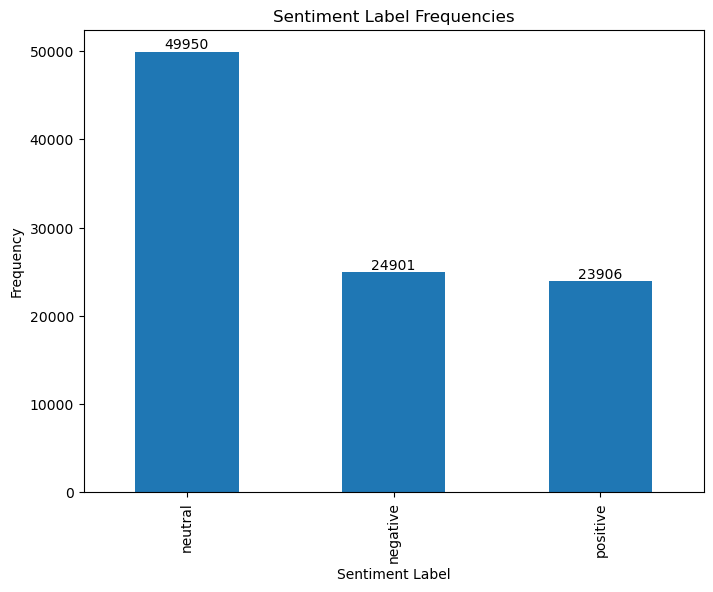

In [88]:
# count the frequency of each sentiment label
sentiment_counts = df.sentiment_label.value_counts()

# create a column plot
fig, ax = plt.subplots(figsize=(8,6))
sentiment_counts.plot(kind='bar', ax=ax)

# set the plot title and axis labels
ax.set_title('Sentiment Label Frequencies')
ax.set_xlabel('Sentiment Label')
ax.set_ylabel('Frequency')

# add data labels to the top of each column
for i, freq in enumerate(sentiment_counts):
    ax.text(i, freq, str(freq), ha='center', va='bottom')

# display the plot
plt.show()

### 4.2 Removing Stopwords

In [90]:
# Extracting english stopwords from processed tweets
sw = stopwords.words('english')
df['processed_tweet_without_stopwords'] = df['processed_tweet'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [91]:
df.head()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount,OnlyDate,OnlyHour,OnlyMin,processed_tweet,sentiment_label,sentiment_score,processed_tweet_without_stopwords
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0,2023-03-21,23.0000,59.0000,chatgpt is another woke machine.,negative,0.8628,chatgpt another woke machine.
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #推特账号 m...",0,0,0,0,2023-03-21,23.0000,59.0000,"of the atlantic, or only near the atla more to...",neutral,0.8373,"atlantic, near atla greenness th"
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0,2023-03-21,23.0000,59.0000,this thread is saved to your notion database. ...,neutral,0.8854,thread saved notion database. tags: [chatgpt]
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI – ChatGPT #0018,1,0,0,0,2023-03-21,23.0000,59.0000,prompt ai – chatgpt,neutral,0.8958,prompt ai – chatgpt
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0,2023-03-21,23.0000,59.0000,just had some interesting conversations with g...,positive,0.9558,interesting conversations googles bard. appear...


### 4.3 Creating New Dataframes based Label and Most Frequent Words

In [93]:
# create new data frames for each sentiment label
df_positive = df[df["sentiment_label"] == "positive"]
df_neutral = df[df["sentiment_label"] == "neutral"]
df_negative = df[df["sentiment_label"] == "negative"]

In [96]:
# with stopwords
#get_top_words(df_positive, "processed_tweet", 20)

# without stopwords
get_top_words(df_positive, "processed_tweet_without_stopwords", 20)

[('.', 23809),
 (',', 18607),
 ('chatgpt', 14976),
 ('!', 8800),
 ('$', 7605),
 (':', 4597),
 ('ai', 4415),
 ('’', 3297),
 ('gpt', 2625),
 ('?', 2600),
 ('chat', 2548),
 (')', 2379),
 ('gpt4', 2154),
 ('like', 2060),
 ('(', 2022),
 (';', 1982),
 ('use', 1964),
 ('&', 1725),
 ('new', 1679),
 ('s', 1598)]

In [97]:
# with stopwords
#get_top_words(df_neutral, "processed_tweet", 20)

# without stopwords
get_top_words(df_neutral, "processed_tweet_without_stopwords", 20)

[('chatgpt', 33505),
 ('.', 30026),
 (',', 28906),
 (':', 11659),
 ('?', 10638),
 ('ai', 6905),
 ('chat', 6442),
 ('gpt', 5689),
 ('’', 5515),
 (')', 3829),
 ('(', 3681),
 ('use', 3495),
 ('!', 3355),
 ('``', 3079),
 ('like', 3021),
 ('s', 2903),
 (';', 2886),
 ("''", 2696),
 ('using', 2672),
 ('&', 2328)]

In [100]:
# Group the dataframe by values in "sentiment_label" column and calculate the mean of other columns for each group
df.groupby("sentiment_label").mean()[["ReplyCount", "RetweetCount", "LikeCount", "QuoteCount", "sentiment_score"]]

,ReplyCount,RetweetCount,LikeCount,QuoteCount,sentiment_score
sentiment_label,,,,,
negative,1.0635,1.0144,9.5778,0.1429,0.7391
neutral,0.9285,1.0083,7.1027,0.1893,0.7369
positive,2.5156,2.5988,15.6156,0.5254,0.8046


### 4.4 Labeled Tweets per Day

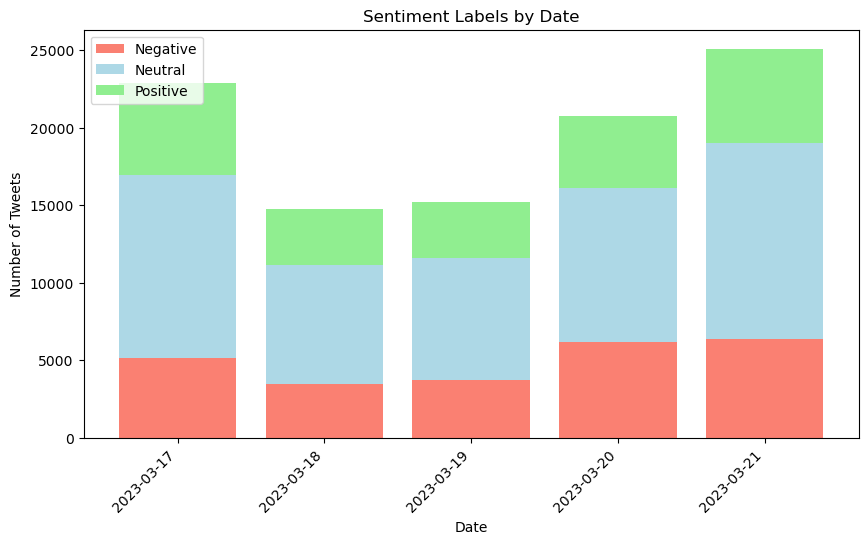

In [101]:
# pivot table to get the count of sentiment labels for each date
pivoted_df = pd.pivot_table(df[["OnlyDate", "sentiment_label"]], index='OnlyDate', columns='sentiment_label', aggfunc=len, fill_value=0)

# create bar chart
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(pivoted_df.index.values, pivoted_df['negative'], color='salmon', label='Negative')
ax.bar(pivoted_df.index.values, pivoted_df['neutral'], bottom=pivoted_df['negative'], color='lightblue', label='Neutral')
ax.bar(pivoted_df.index.values, pivoted_df['positive'], bottom=pivoted_df['neutral']+pivoted_df['negative'], color='lightgreen', label='Positive')

# set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets')
ax.set_title('Sentiment Labels by Date')

# rotate x-axis labels if needed
fig.autofmt_xdate(rotation=45)

# add legend
ax.legend(loc='upper left')

# show the plot
plt.show()

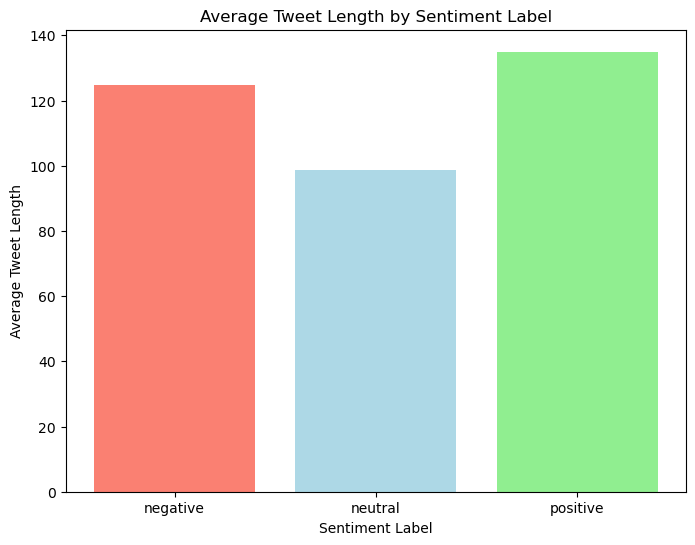

In [102]:
# calculate tweet lengths and add to dataframe
df['TweetLength'] = df['processed_tweet'].astype(str).apply(len)

# group by sentiment_label and calculate average tweet length
grouped = df.groupby('sentiment_label')['TweetLength'].mean()

# create bar chart
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(grouped.index, grouped.values, color=['salmon', 'lightblue', 'lightgreen'])

# set axis labels and title
ax.set_xlabel('Sentiment Label')
ax.set_ylabel('Average Tweet Length')
ax.set_title('Average Tweet Length by Sentiment Label')

# show the plot
plt.show()

### 4.4 Relationship between Retweet and Like

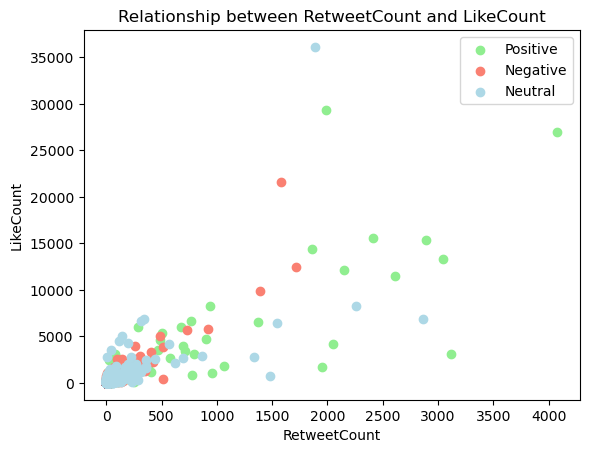

In [103]:
# Scatter plot for showing the relationship between RetweetCount and LikeCount variables, colored by sentiment_label
plt.scatter(df[df['sentiment_label'] == 'positive']['RetweetCount'], 
            df[df['sentiment_label'] == 'positive']['LikeCount'], c='lightgreen', label='Positive')

plt.scatter(df[df['sentiment_label'] == 'negative']['RetweetCount'], 
            df[df['sentiment_label'] == 'negative']['LikeCount'], c='salmon', label='Negative')

plt.scatter(df[df['sentiment_label'] == 'neutral']['RetweetCount'], 
            df[df['sentiment_label'] == 'neutral']['LikeCount'], c='lightblue', label='Neutral')

# Set the title, x and y axis labels
plt.title('Relationship between RetweetCount and LikeCount')
plt.xlabel('RetweetCount')
plt.ylabel('LikeCount')

# Add legend
plt.legend()

# Show the plot
plt.show()

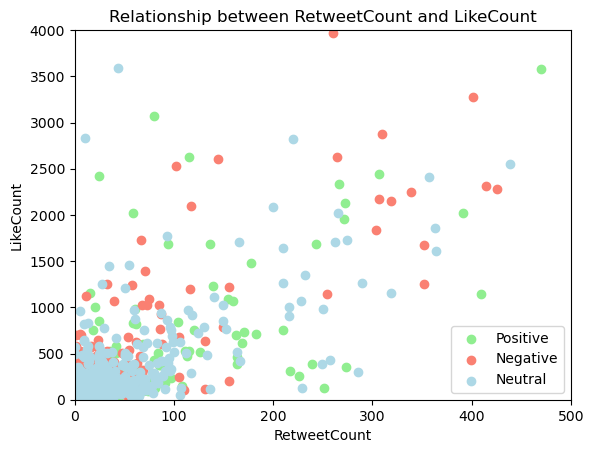

In [104]:
# Scatter plot for showing the relationship between RetweetCount and LikeCount variables, colored by sentiment_label
plt.scatter(df[df['sentiment_label'] == 'positive']['RetweetCount'], 
            df[df['sentiment_label'] == 'positive']['LikeCount'], c='lightgreen', label='Positive')

plt.scatter(df[df['sentiment_label'] == 'negative']['RetweetCount'], 
            df[df['sentiment_label'] == 'negative']['LikeCount'], c='salmon', label='Negative')

plt.scatter(df[df['sentiment_label'] == 'neutral']['RetweetCount'], 
            df[df['sentiment_label'] == 'neutral']['LikeCount'], c='lightblue', label='Neutral')

# Set the title, x and y axis labels
plt.title('Relationship between RetweetCount and LikeCount')
plt.xlabel('RetweetCount')
plt.ylabel('LikeCount')

# x and y axis limits
plt.xlim(0, 500)
plt.ylim(0, 4000)

# Lejantı ekle
plt.legend()

# Grafik göster
plt.show()

## 5. WordCloud

In [105]:
def plot_wordcloud(df, col):
    """
    Plots a wordcloud based on the text data in the specified column of a DataFrame.

    Args:
    df (pd.DataFrame): The DataFrame containing the text data.
    col (str): The name of the column containing the text data.

    Returns:
    None.
    """
    # Concatenate all text data in the specified column into a single string
    text = " ".join(i for i in df[col])

    # Create a wordcloud object
    wc = WordCloud(background_color="white",
                   max_words=1000,
                   contour_width=3,
                   contour_color="firebrick",
                   width=800, height=400).generate(text)

    # Plot the wordcloud
    plt.figure(figsize=(12,8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### 5.1 WordCloud of Whole Dataframe

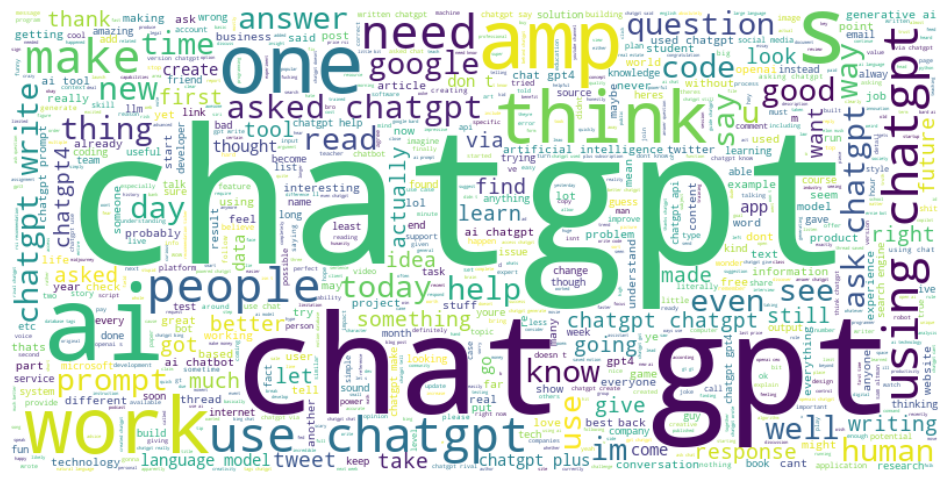

In [106]:
plot_wordcloud(df, "processed_tweet_without_stopwords")

### 5.2 Positive Tweets' WordCloud

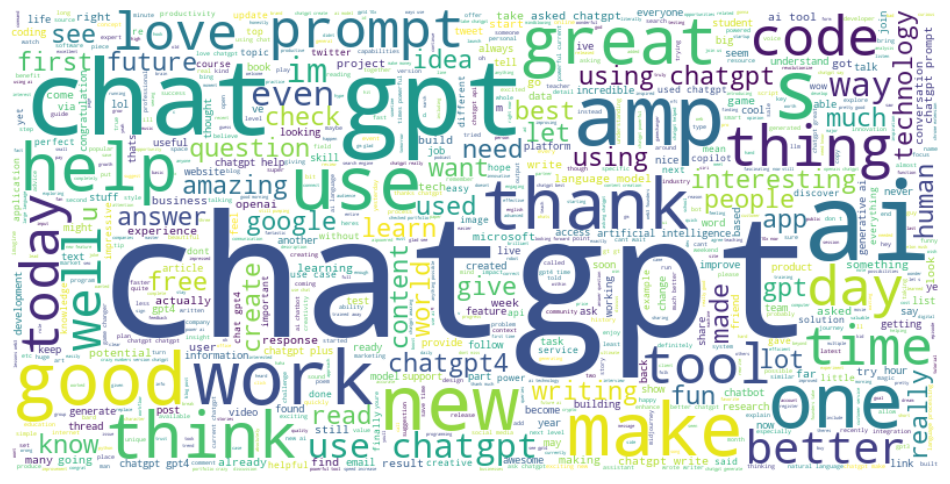

In [109]:
plot_wordcloud(df_positive, "processed_tweet_without_stopwords")

### 5.3 Neutral Tweets' WordCloud

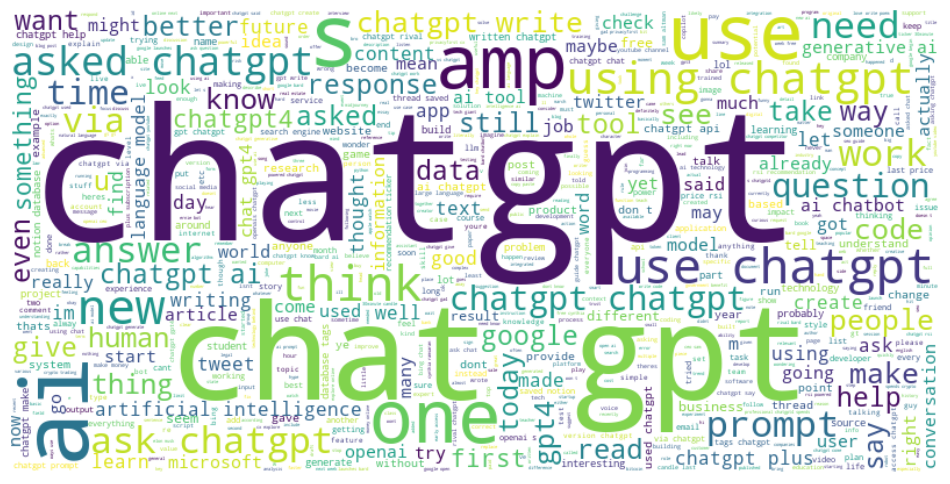

In [108]:
plot_wordcloud(df_neutral, "processed_tweet_without_stopwords")

### 5.4 Negative Tweets' WordCloud


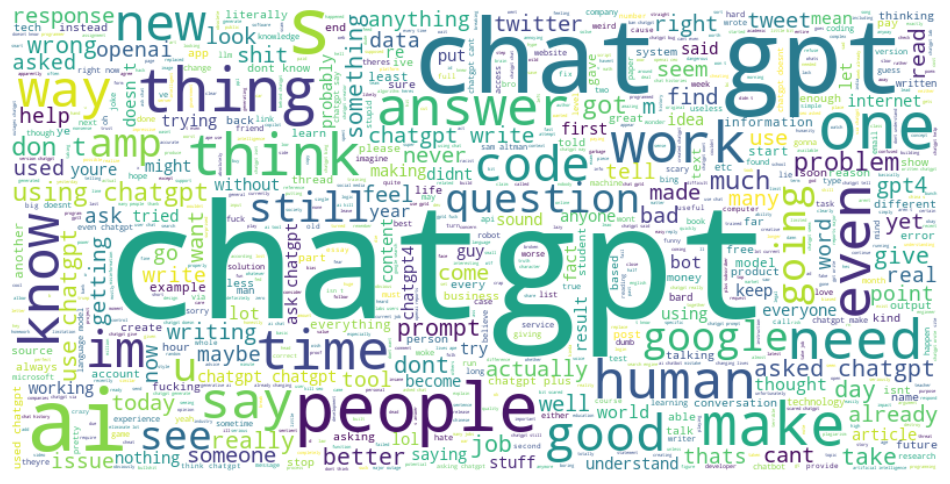

In [107]:
plot_wordcloud(df_negative, "processed_tweet_without_stopwords")

## 6. Last Notes

### 6.1 References
* Thanks to;
    * Miuul x Veri Bilimi Okulu
    * Yavuz Kömeçoğlu
    * MoreThan101

### 6.2 Discussion
* I would love to hear if you have reviewed my work and have any comments or feedback to improve it for my next work.
* If you do a project using the data from the study, I would be very interested in looking into it.
* I am waiting for your **comment** and **upvote** if you like the study and the dataset.
* Thank you for everything!